# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

First part:
- Implement linear regression model 
    - using least squares method
    - implement directly using the NumPy package

Second part:
- regularization
- polynomial basis expansion
- cross validation
- scikit-learn: https://scikit-learn.org/

You will need to use the following:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

For the purpose of testing, we’ll use the winequality dataset. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality In order to make it easier to import the dataset, we’ve converted the data to the numpy array format and shuffled it so that you can start the practical directly. The dataset is available on the course website. 

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. You can load the data from the files as follows:

In [2]:
# load the dataset
# X is a matrix such that each row stores a data record 
# y is a vector of the corresponding labels of the records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a matrix with shape {}, which has {} records and {} attributes.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a vector with {} values, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a matrix with shape (4898, 11), which has 4898 records and 11 attributes.
y is a vector with 4898 values, which stores the corresponding labels of the data records in X


In order to get consistent results, all students should use the same 80% of the data as training
data. We’ll use the remaining as test data. To achieve this split run the following:

In [3]:
# The function splits the dataset into the training dataset and the test dataset.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset, 
# and the remaining data goes to the test dataset.
def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # use 80% of the data as training data

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


We’ll not touch the test data except for reporting the errors of our learned models

## Understanding What We’re Predicting

Before we get to training a linear model on the data and using it to make predictions, let’s look
at the spread of y values on the training set. The values are integers between 3 and 9 indicating
the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y values appearing in the training data.

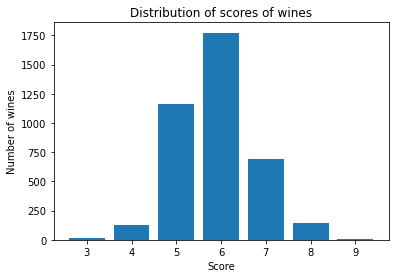

In [4]:
#@title
# Task 1: 
# the function takes the training dataset as the input, and make the bar chart
def plot_bar_chart_score(X_train, y_train):
    ###################################################
    unique, counts = np.unique(y_train, return_counts=True)
    unique = unique.astype('int64')
    plt.bar(unique,counts) # draw the plot
    plt.title("Distribution of scores of wines") # add title
    plt.xlabel("Score") # add x axis caption
    plt.ylabel("Number of wines") # add y axis caption
    plt.show() # show the plot
    ###################################################

plot_bar_chart_score(X_train, y_train)

### **Task 2** 
Implement the trivial predictor, which uses the average value of y on the training set as the prediction for ever datapoint. 

In [5]:
#@title
# Task 2: implement the simplest predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
    ###################################################
    # returns the mean of y
    return np.mean(y_train)
    ###################################################

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The simplest predictor returns the average value.
def simplest_predictor(X_test, y_train_avg):
  return y_train_avg


Average of y on the training label values is 5.878764675855028


### **Task 3**
Report the mean squared error, i.e., the average of the squared residuals, using this simplest of predictors on the training and test data. We should hope that our models beat at lease this baseline. 

In [6]:
# We will evaluate our simplest predictor here. 
# Implement a function that can report the mean squared error 
# of a predictor on the given test data
# Input: test dataset and predictor
# Output: mean squared error of the predictor on the given test data
def test_data(X_test, y_test, predictor: callable=None):
    # applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)

    # computing the mean squared error of y_predicted
    ###################################################
    # We do not divide the mse by 2 as in the lecture slides.
    # We stick to this approach throughout the whole Practical 1
    mse = np.mean((y_predicted-y_test) ** 2)
    ###################################################
    
    return mse

# use the above function test_data to evaluate the simplest predictor
# we use the lambda function here to pass the function simplest_predictor to the evaluator.
mse_simplest_predictor_train = test_data(X_train, y_train, lambda x: simplest_predictor(x, y_train_avg))
mse_simplest_predictor_test = test_data(X_test, y_test, lambda x: simplest_predictor(x, y_train_avg))

# Report the result
print('Simplest Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_simplest_predictor_train)
print('MSE (Testing)  = %.4f' % mse_simplest_predictor_test)

Simplest Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Linear Model Using Least Squares

Let us first fit a linear regression model and then calculate the training and test error. We’ll
actually use the closed form solution of the least squares estimate for the linear model. 


### **Task 4**
Is it strictly necessary to standardize the data for the linear model using the least squares method? Why?

It is not strictly necessary to standardize the data, as the least squares method has a closed-form solution. Thus, shifting and scaling the data (the independent variables) do not have an effect on the predicted dependent variable. Scaling simply corresponds to (inverse) scaling the corresponding weights, whereas shifting does not affect the weights (except for the bias term).

However, if the model contains polynomial or interaction terms, standardizing the independent variables can help reduce multicollinearity produced by higher-order terms. In addition, standardization would prevent the interaction terms from being affected by the different scales of the independent variables.

### **Task 5**
Standardize the data, i.e., make the data for every feature have mean 0 and variance 1. 

We do the standardization using the training data, and we need to remember the means and
the standard deviations so that they can be applied to the test data as well. Apply the
standardization so that every feature in the training data has mean 0 and variance 1. Apply
the same transformation to the test data. 

In [7]:
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    # computing mean, standard deviations and the standardized data
    ###################################################
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean)/std
    ###################################################
    
    return X_std, mean, std

X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [8]:
# standardizing the test data using the mean and standrad deviation computed for the training data
###################################################
X_test_std = (X_test - X_train_mean)/X_train_std_div
print(X_test_std.shape)
###################################################

(980, 11)


### **Task 6**
Implement the linear model predictor, and report the mean squared error using the linear model on the training and test data.

We will do this in several steps. We need to implement the function for computing the parameters based on the training dataset. Note we need to add the bias column to the dataset. 

In [9]:
# the function adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    # adds a column of ones to the front of the input matrix
    ###################################################
    vec = np.ones((X.shape[0], 1))
    X_out = np.hstack((vec, X))
    return X_out
    ###################################################

# The function computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the dataset
    X = expand_with_ones(X_input)

    # computes the parameters based on the expanded X and y
    ###################################################
    T = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    return T
    ###################################################

# train the linear model parameters
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


We then implement the linear model predictor given the dataset and the parameters. 

In [10]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    # computes the predicted values based on the test dataset and the parameters
    ###################################################
    return X.dot(w)
    ###################################################


We can now evaluate our linear model predictor on the test dataset. 

In [11]:
# use the function test_data to evaluate the linear model predictor
mse_linear_model_predictor = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283469


## Learning Curves

Let us see if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, our guess should be that it may either be underfitting or be about right.

Starting with 20 datapoints, we’ll use training datasets of increasing size, in increments of 20 up to about 600 datapoints. For each case train the linear model only using the first n elements of
the training data. Calculate the training error (on the data used) and the test error (on the full test set). Plot the training error and test error as a function of the size of the dataset used for
training.

### **Task 7** 
Implement a function that evaluates the linear model over the training dataset with the input size.
The function takes a dataset and the split coefficient as inputs, and
1. splits the data to training and test datasets,
2. standardizes the data,
3. trains the linear model, and
4. reports the mse of the linear model predictor on both training and test datasets. 

In [12]:
# Defining a global variable train_size, which determines the size of the
# training dataset on which the linear model is being trained. The model
# is tested on the whole test dataset
train_size = X_train.shape[0]

# Input: dataset and split coefficient
# Output: mse of the linear model predictor on both the training and test datasets
def train_and_test(X, y, split_coeff):
    # implements the function, using already implemented functions
    ###################################################
    X_train, y_train, X_test, y_test = split_data(X, y, split_coeff)
    X_train_std_trsi, X_train_mean_trsi, X_train_std_div_trsi = standardize_data(X_train[:train_size])
    X_test_std = (X_test - X_train_mean_trsi)/X_train_std_div_trsi
    w_trsi = least_squares_compute_parameters(X_train_std_trsi, y_train[:train_size])
    mse_train = test_data(expand_with_ones(X_train_std_trsi), y_train[:train_size], lambda x: linear_model_predictor(x, w_trsi))
    mse_test = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w_trsi))
    return mse_train, mse_test
    ###################################################

mse_train, mse_test = train_and_test(X, y, 0.8)
print('MSE using Linear Models')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


MSE using Linear Models
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5607


### **Task 8**
Report the learning curves plot. Also, explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

480


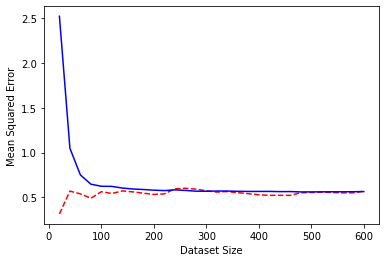

In [13]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the errors over datasets with different sizes
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    # Computes the training error and test error on datasets with size train_size
    # and add them to mse_train_v and mse_test_v, respectively
    ###################################################
    mse_train, mse_test = train_and_test(X, y, 0.8)
    ###################################################
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)

# Printing the optimal number of training data for achieving
# the lowest test error
mse_idx_min = np.argmin(np.array(mse_test_v))
print(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20)[mse_idx_min])

# The below code outputs the plot of mse from different training sizes
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

From the plot it seems like the model could be underfitting. The reason for that is that the training error and test error curves approach each other already at the beginning and then stay level. It does not matter whether we use more data to train the model, both errors stay nearly the same. The test error does not improve after the point of 480 data points. Furthermore, both errors plateau at a level around 0.56 (which is far from 0.00), therefore it seems reasonable to check whether a more complex model would result in an improvement in the mean squared error.

## Polynomial Basis Expansion with Ridge and Lasso

For this part use the following from the scikit-learn package. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html



You will need the use the following:

In [14]:
# You will need the following libs. 
# Fell free to import other libs. 

# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

Try 5 powers of 10 for lambda from 10^-2 to 10^2 and use degree 2 basis expansion. Fit ridge and lasso using degree 2 polynomial expansion with these values of lambda. You should pick the optimal values for lambda using a validation set. Set the last 20% of the training set for the purpose of validation.

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [15]:
def expand_basis(X, degree):
    # expands the basis of X for the degree, using the function PolynomialFeatures
    ###################################################
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)
    ###################################################

### **Task 10**
Prepare the training, test and validation data using the expanded dataset. Expand and standardize the the data. 

Hints: you can use `StandardScaler` and `std_scaler` to standardize the data

In [16]:
# Pre-processing the training, test and validation data using the expanded dataset
def prepare_data(X, y, degree):
    ###################################################
    
    # splitting the data to training and test data
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)
    # standardising the training data and doing the same transformation to the test data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # expanding the basis of the training data and test data
    X_train = expand_basis(X_train, degree)
    X_test = expand_basis(X_test, degree)

    # splitting the training data to training and validation data
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)
    # standardising the training data and doing the same transformation to the validation data
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train_n)
    X_train_v = scaler.transform(X_train_v)

    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test
    ###################################################

X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyper parameter lambda for Ridge and Lasso using the validation data. 


Ridge lambda: 1
Lasso lambda: 0.001


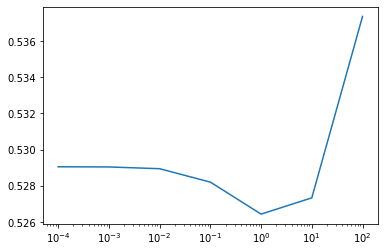

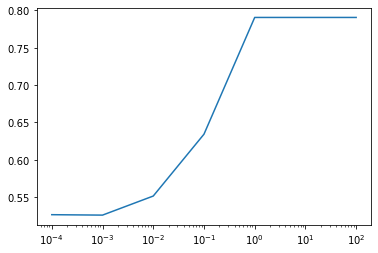

In [17]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that has the minimal mse
# We use is_ridge to indicate the model we consider. 
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    # Try lambda values from 10^-4 to 10^2 (following suggestion from OLAT Forum).
    # Record the mse and the lambda values in mse_arr and lam_arr
    ###################################################
    for pow_lam in range(-4, 3):
        lam = 10 ** pow_lam
        
        if is_ridge:
            reg = Ridge(alpha=lam)
        else:
            reg = Lasso(alpha=lam, max_iter=2500)
            
        reg.fit(X_train_n, y_train_n)
        y_predicted = reg.predict(X_train_v)
        
        # We do not divide the mse by 2 as in the lecture slides.
        # We stick to this approach throughout the whole Practical 1
        mse = np.mean((y_predicted-y_train_v) ** 2)
        
        mse_arr.append(mse) # add the mse when using the hyperparameter lam
        lam_arr.append(lam)
    ###################################################

    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))
    # print(lam_arr[lambda_idx_min])

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the best lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal values for lambda for Ridge and Lasso, train these models using these hyperparameters on the full training data. Then report
the training and test error.

In [18]:
# training the Ridge and Lasso models using their best parameters, and
# reporting their mse
###################################################

# We have expanded the training and test data. Therefore we need to standardise them
# again (according to OLAT Forum - Ridge and Lasso regularisation require the data to
# have mean of 0 and standard deviation of 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# training the models on the full training data

reg_ridge = Ridge(alpha=lam_ridge)
reg_ridge.fit(X_train, y_train)
mse_ridge_train = np.mean((reg_ridge.predict(X_train)-y_train) ** 2)
mse_ridge_test = np.mean((reg_ridge.predict(X_test)-y_test) ** 2)

# max_iter is set to 2500 to make sure that the algorithm converges
# and no ConvergenceWarning appears
reg_lasso = Lasso(alpha=lam_lasso, max_iter=2500)
reg_lasso.fit(X_train, y_train)
mse_lasso_train = np.mean((reg_lasso.predict(X_train)-y_train) ** 2)
mse_lasso_test = np.mean((reg_lasso.predict(X_test)-y_test) ** 2)

###################################################

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 1.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4952
MSE (Testing)  = 0.5126


For Lasso with using degree 2 polynomial expansion and lambda = 0.0010
---------------------------------------------------------------------

MSE (Training) = 0.4966
MSE (Testing)  = 0.5101


## Larger Degrees



### **Task 13**
Try using higher degree basis expansion. You may want to use k-fold cross validation to determine
the values of hyperparameters rather than just keeping a validation set. 

Hints: Use `KFold` to do this automatically. 

In [19]:
# KFold
from sklearn.model_selection import KFold

# IMPORTANT!!!
# Running this part of the notebook may take a considerable amount of time (no use of GPU, around 15 minutes).
# You could take a look at the generated plots instead ('Ridge_degrees_plot.png', 'Ridge_degrees_plot_ylim.png'
# and 'Lasso_degrees_plot.png'). From them it is clear that 2 is the optimal degree of basis expansion.

# Trying out different degrees of basis expansion. Opting to find the degree that gives the minimal mse. 
###################################################
kf = KFold(n_splits=5)

d_data = {}

# We will try degree of basis expansion from 1 to 5 
for d in range(1, 6):
    
    X_train, y_train, _, _, _, _, _, _ = prepare_data(X, y, d)
    
    mse_ridge_avg_arr = []
    mse_lasso_avg_arr = []
    lam_arr = []
    
    # The lambda values we will use as hyperparameters are the same as in Task 11
    for pow_lam in range(-4, 3):
        
        mse_ridge_arr = []
        mse_lasso_arr = []
        
        # Using Kfold to calculate cross-validation errors for the fixed values of
        # the degree and lambda
        for train_n_index, train_v_index in kf.split(X_train):
            
            X_train_n, X_train_v = X_train[train_n_index], X_train[train_v_index]
            y_train_n, y_train_v = y_train[train_n_index], y_train[train_v_index]

            # standardising the training data and doing the same transformation to the validation data
            scaler = StandardScaler()
            X_train_n = scaler.fit_transform(X_train_n)
            X_train_v = scaler.transform(X_train_v)
            
            lam = 10 ** pow_lam
            
            reg_ridge = Ridge(alpha=lam)
            reg_ridge.fit(X_train_n, y_train_n)
            mse_ridge = np.mean((reg_ridge.predict(X_train_v)-y_train_v) ** 2)
            
            # Increasing max_iter to make sure that the algorithm converges
            # increases the runtime substantially. Therefore we keep max_iter low,
            # at the cost that the predictions and consequently the mean squared errors
            # may not be entirely correct
            reg_lasso = Lasso(alpha=lam, max_iter=2500)
            reg_lasso.fit(X_train_n, y_train_n)
            mse_lasso = np.mean((reg_lasso.predict(X_train_v)-y_train_v) ** 2)
            
            mse_ridge_arr.append(mse_ridge)
            mse_lasso_arr.append(mse_lasso)
        
        # We will collect the average of the 5 validation errors from the 5-Kfold-
        # cross-validation
        mse_ridge_avg = np.mean(np.array(mse_ridge_arr))
        mse_lasso_avg = np.mean(np.array(mse_lasso_arr))
        mse_ridge_avg_arr.append(mse_ridge_avg)
        mse_lasso_avg_arr.append(mse_lasso_avg)
        lam_arr.append(lam)
    
    # We are collecting the average cross-validation error for the different values of
    # the degree and lambda for Ridge and Lasso in a dictionary
    d_data[str(d) + '_ridge'] = mse_ridge_avg_arr
    d_data[str(d) + '_lasso'] = mse_lasso_avg_arr
###################################################

C:\Users\nightmare\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.847832562487838, tolerance: 0.24286818761965553
  model = cd_fast.enet_coordinate_descent(
C:\Users\nightmare\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.369333582248828, tolerance: 0.2422490427568606
  model = cd_fast.enet_coordinate_descent(
C:\Users\nightmare\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.7624606281529, tolerance: 0.24151814992025522
  model = cd_fast.enet_coordinate_descent(
C:\Users\nightmare\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

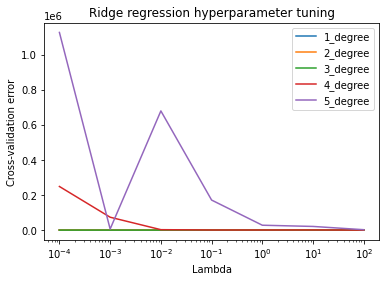

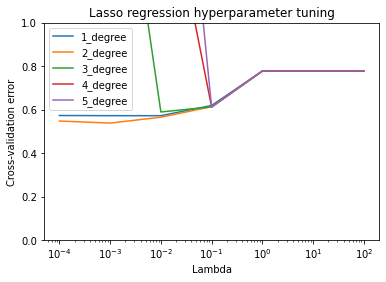

In [27]:
# Generating plots to show the average cross-validation error for different
# values of lambda and the degree of basis expansion

for k in [list(d_data.keys())[x] for x in range(len(d_data.keys())) if x % 2 == 0]:
    plt.semilogx(lam_arr, d_data[k], label = k[0] + '_degree')
# when using a smaller scale of the y axis only the lines for 1 and 2 degree are visible
# plt.ylim(0, 1)
plt.title('Ridge regression hyperparameter tuning')
plt.xlabel("Lambda")
plt.ylabel("Cross-validation error")
plt.legend()
plt.savefig('Ridge_degrees_plot.png')
plt.show()

for k in [list(d_data.keys())[x] for x in range(len(d_data.keys())) if x % 2 == 1]:
    plt.semilogx(lam_arr, d_data[k], label = k[0] + '_degree')
plt.title('Lasso regression hyperparameter tuning')
plt.ylim(0, 1)
plt.xlabel("Lambda")
plt.ylabel("Cross-validation error")
plt.legend()
plt.savefig('Lasso_degrees_plot.png')
plt.show()

# From the generated plots it is visible that a higher degree of basis expansion does not lead
# to an improvement in the model's performance. A degree of 2 seems to be the optimal choice.

## Short report

This practical gave us a very nice overview of the basics of model training and evaluation. We learned how to apply the concepts covered during the lecture on a real-life problem (specifically data standardization, Linear Least Square Error parameter estimation, evaluation of a trained model on a test dataset, polynomial basis expansion, hyperparameter tuning on a fixed validation set and hyperparameter tuning with cross-validation).

What we found most difficult about this practical was the correct standardization of the data (in Tasks 10, 12 and 13). The explanations on OLAT helped us a lot for understanding the correct order of standardization. In addition, we discussed in our group for quite a while what our answer to the question of Task 4 should be.

We (Fabian; Pascal - before dropping out; Vladimir) completed Practical 1 together, in the course of a couple of MS Teams sessions. The final review of the code and the consequent improvements were made by Vladimir.